In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

: 

: 

In [ ]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [ ]:
import numpy as np 

# Read input data: digit images

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/home/mchristos/.fastai/data/mnist_sample/labels.csv'),Path('/home/mchristos/.fastai/data/mnist_sample/valid'),Path('/home/mchristos/.fastai/data/mnist_sample/train')]

We have a training and validation set of mnist digits 3 and 7 

In [ ]:
threePaths = (path/'train'/'3').ls()
sevenPaths = (path/'train'/'7').ls()

Run below to see a random three or seven image

In [ ]:
randomIndex = np.random.randint(len(threePaths))
im3=Image.open(threePaths[randomIndex])
im3

In [ ]:
randomIndex = np.random.randint(len(sevenPaths))
im7=Image.open(sevenPaths[randomIndex])
im7

In [ ]:
tensor(im3)[4:30,4:20]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,  18, 171, 233,  18,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  43, 207, 254, 254, 207,  88,  21,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 201, 254, 254, 254, 254, 254, 237,  25,   0],
        [  0,   0,   0,   0,   0,   0,   0, 162, 254, 254, 254, 254, 254, 254,  54,   0],
        [  0,   0,   0,   0,   0,   0,   0,  15,  53,  53,  78, 254, 254, 254,   9,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  18, 149, 254, 254, 252,   8,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  20, 146, 254, 254, 254, 144,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 128, 214, 254, 254, 254, 225,   2,   0,   0],
        [  0,   0,   0,   0,   0,   0,  80, 254, 254, 254, 254, 254, 247,  70,   0,   0],
        [  0,   0,   0,   0,   0,   0,  86, 254, 254, 254, 254, 254, 254, 245, 102,   0],
        [  0,   0,   0,   0,   0,   0,  45, 109,  44,  44,  98, 236, 254, 254, 243,  18],
        [ 

# First Model

In [ ]:
threes = [tensor(Image.open(x)) for x in threePaths ]
sevens = [tensor(Image.open(x)) for x in sevenPaths ]

In [ ]:
print(len(threes), len(sevens))

6131 6265


<AxesSubplot:>

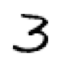

In [ ]:
show_image(threes[0])

In [ ]:
stacked_threes = torch.stack(threes).float()
stacked_sevens = torch.stack(sevens).float()

In [ ]:
print(stacked_threes.min(), stacked_threes.max())
print(stacked_threes.min(), stacked_sevens.max())

tensor(0.) tensor(255.)
tensor(0.) tensor(255.)


Image pixel values are between 0 and 255 so we can scale it to be between - and 1 

In [ ]:
stacked_threes = torch.stack(threes).float()/255
stacked_sevens = torch.stack(sevens).float()/255

In [ ]:
stacked_threes.shape

torch.Size([6131, 28, 28])

In [ ]:
len(stacked_threes)

6131

We now have all our images stacked up in a single tensor (can imagine a cube stacked up with 2D images). Each image is 28 x 28, and for threes we have 6131 images. Interestingly the len() of these pytorch tensors are the rank (or dimension), i.e. 3

<AxesSubplot:>

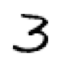

In [ ]:
show_image(stacked_threes[0])

## compute the "average" 3

We simply compute the mean over all images, i.e. mean along the 0 axis (the one of length number of images)

<AxesSubplot:>

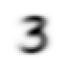

In [ ]:
mean_three = stacked_threes.mean(0)
show_image(mean_three)

<AxesSubplot:>

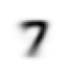

In [ ]:
mean_svn = stacked_sevens.mean(0)
show_image(mean_svn)

In [ ]:
type(mean_three)

torch.Tensor

In [ ]:
def classify(image: torch.Tensor):
    """
    Classify as 28 x 28 image represented as a pytorch tensor
    
    Returns the digit which has the least mean squared distance from the image. i.e. we decide if itsa seven or a three 
    by seeing which "ideal" digit its closest to
    """
    distance_three = ((image - mean_three)**2).sum().sqrt()
    # or, compute this with the pytorch loss function MSE (mean squared error) 
    distance_three = F.mse_loss(image, mean_three).sqrt()
    distance_svn = F.mse_loss(image, mean_svn).sqrt()
    return 0 if distance_svn < distance_three else 1

## Evaluate our classifier on the test set 

In [ ]:
testThrees = [tensor(Image.open(p)) for p in (path/'valid'/'3').ls()]
testSvns = [tensor(Image.open(p)) for p in (path/'valid'/'7').ls()]

In [ ]:
X = testThrees + testSvns
y = tensor(len(testThrees)*[1] + len(testSvns)*[0]) 

In [ ]:
y_pred = tensor([classify(x) for x in X])

In [ ]:
y_pred

tensor([1, 1, 1,  ..., 1, 0, 0])

In [ ]:
accuracy = 1- ((y - y_pred)**2).sum()/len(y)
accuracy

tensor(0.9475)

In [ ]:
# Precision on predicting 3 
# i.e. out of all the times we predicted 3, what fraction was correct? 
precision_3 = torch.logical_and(y_pred == 1,y == y_pred).sum() / (y_pred==1).sum()
precision_3

tensor(0.9161)

In [ ]:
# Recall on digit 3 
# i.e. out of all the true 3 digits, what fraction did we "hit"? 
recall_3 = torch.logical_and(y == 1,y == y_pred).sum() / (y==1).sum()
recall_3

tensor(0.9842)

Our recall is more than 98%, so almost all of the actual 3's we predict correctly. OUr precision on 3 is a bit lower, so that means that we're predicting 3 on some digits that were actually a 7. As you can see below, we are predicting 1085 digits to be a 3 but there are only 1010 true 3s.

In [ ]:
print((y_pred==1).sum())
print((y==1).sum())

tensor(1085)
tensor(1010)


Overall pretty damn impressive for such a naive algorithm! 

## Vectorize that code 

I wrote that off the top of my head, and one bad thing I did is use a python loop (list comprehension) to compute all the predictions in batch on the validation set. Lets rather do this in a vectorized manner 

In [ ]:
def mnist_distance(im_a, im_b): return ((im_a - im_b)**2).sum().sqrt()
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

In [ ]:
valid_3s = torch.stack([tensor(Image.open(p)) for p in (path/'valid'/'3').ls()]).float()/255
valid_7s = torch.stack([tensor(Image.open(p)) for p in (path/'valid'/'7').ls()]).float()/255

In [ ]:
def is_3(image): return mnist_distance(image, mean_three) < mnist_distance(image, mean_svn)

In [ ]:
X_val = torch.stack([*valid_3s, *valid_7s])
y_val = tensor(len(valid_3s)*[1] + len(valid_7s)*[0]).float()

In [ ]:
y_pred = is_3(X_val).float()

In [ ]:
accuracy = (y_pred == y_val).sum() / len(y_val)
accuracy

tensor(0.9514)

In [ ]:
precision_3 = torch.logical_and(y_pred == 1,y_val == y_pred).sum() / (y_pred==1).sum()
precision_3

tensor(0.9841)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[1013,   15],
       [  84,  926]])

## Training a REAL model 

lets prepare our training data - we'll flatten each image into a single vector (28x28=784) and use 784 weights, one for each pixel. 

In [ ]:
threes = [tensor(Image.open(x)) for x in (path/'train'/'3').ls() ]
sevens = [tensor(Image.open(x)) for x in (path/'train'/'7').ls() ]
stacked_3s = torch.stack(threes).float()/255
stacked_7s = torch.stack(sevens).float()/255

In [ ]:
print(stacked_3s.shape)
print(stacked_7s.shape)

torch.Size([6131, 28, 28])
torch.Size([6265, 28, 28])


In [ ]:
# cast each 2d image into a 1d array 
train_x = torch.cat([stacked_3s, stacked_7s]).view(-1,28*28)
train_x.shape

torch.Size([12396, 784])

In [ ]:
# in python list1 + list2 concatenates the contents of the two lists
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
# y = w*x + b
weights = init_params(28*28)
bias = init_params(1)

In [ ]:
def linear1(X):
    return X@weights + bias